In [155]:
# --- PACKAGED INSTALLATION ---
# pip install numpy
# pip install pandas
# pip install sklearn
# pip install scipy
# pip install matplotlib
# pip install seaborn
# pip install imblearn
# !pip install cmake                # for installing xgboost
# pip install -r requirements.txt   # for installing xgboost
# pip install xgboost


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import csv

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification

import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import xgboost as xgb 
from xgboost import XGBClassifier

from time import process_time
from datetime import datetime
from scipy.stats import pearsonr
from collections import Counter

## 1. XGBoost default parameters without feature engineering

In [156]:
# inputing data
features = pd.read_csv("features_v3.csv")

#### Data Preparation

In [157]:
# set up 
remove_alerts = True
class_balance = True
num_top_features = 10

to_drop = ['PASS_THROUGH_VALUE_1', 'user_id', 'ts_request_id', 'quoted_at', 'bound_at', 'written_premium', 'canceled_at', 'has_alert']
outcome_name = 'canceled'
model_name = 'cancellation_walerts'
output_dir = 'cancellations_may_update/'

# data preparation
if remove_alerts == True:
    features = features[(features.canceled == 0) | ( (features.canceled == 1) & (features.has_alert == False) )]

# drop non-modeling features 
features = features.drop(columns = to_drop)

# missing to zeros 
features = features.fillna(0)

# fill to zeros 
features = features.replace([np.inf, -np.inf], -1)
features = features.rename(columns = {'canceled' : 'outcome'})

# shuffle dataset
features = shuffle(features, random_state = 2).reset_index(drop = True)

# checking outcome balance
outcome_percent = pd.DataFrame(features['outcome'].value_counts())
outcome_percent['percent'] = outcome_percent['outcome']/sum(outcome_percent['outcome'])
print("Class balance of total set:\n",outcome_percent)


Class balance of total set:
    outcome   percent
0     7467  0.969992
1      231  0.030008


#### Train & Test Splitting

In [158]:
# seperate training features X and class feature y
X = features.loc[:, features.columns != 'outcome']
y = features['outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.6 ,random_state=40)

# check class balance
train_balance_percent = pd.DataFrame(y_train.value_counts())
train_balance_percent['percent'] = train_balance_percent['outcome']/sum(train_balance_percent['outcome'])

test_balance_percent = pd.DataFrame(y_test.value_counts())
test_balance_percent['percent'] = test_balance_percent['outcome']/sum(test_balance_percent['outcome'])

print("Class balance of training set:\n",train_balance_percent)
print("Class balance of testing set:\n",test_balance_percent)

Class balance of training set:
    outcome   percent
0     4475  0.969034
1      143  0.030966
Class balance of testing set:
    outcome   percent
0     2992  0.971429
1       88  0.028571


#### Modeling (with different class ratio & number of features)

##### Resampling function 

There are three methods we can use to resapling for class balacing in this function:

* Oversampling for the manority class
* Undersamling for the majority class
* Combinating both above methods


In [159]:

## Function to resampling by using oversampling, undersampling and combined both 

# oversample for manority class
# undersample for mijority class

def balancing (X, y, ratio, type):
    
    
    """
    Over balacing dataset X and y with ratio = minority/majority 
    Under balacing dataset X and y with ratio = minority/majority
    
    Args:
        X (dataset): unbalanced dataset
        y (dataset): unbalanced dataset
        ratio (float): minority/mojority
        type (chr): "undersampling" or "oversampling"
    Returns:
        X_blc, y_blc, manority_class : balanced datasest, and manority/total num of data
    """
    
    if type == "undersampling":
        balance_tool = RandomUnderSampler(sampling_strategy= ratio) # manority class/majority class
    if type == "oversampling":
        balance_tool = SMOTE(sampling_strategy = ratio) # manority class/majority class
        
    X_blc, y_blc = balance_tool.fit_resample(X, y)
    
    return X_blc, y_blc

In [160]:
## Function to resampling by using oversampling, undersampling and combined both 

# combination, undersampling then oversampling for whole test set
def combined_both (X, y, under_ratio, over_ratio):
    
    
    """
    Firstly, using undersampling to random delete observations from majority class, then using oversampling to resample minority class

    Args:
        X (dataset): unbalanced dataset
        y (dataset): unbalanced dataset
        under_ratio (float): minority/mojority for the fist time resample
        over_ratio (float): minority/mojority for the second time resample(finaln ratio)

    Returns:
        X_blc, y_blc : balanced datasest, and manority/total num of data
    """
    
    under = RandomUnderSampler(sampling_strategy = under_ratio)
    
    over = SMOTE(sampling_strategy = over_ratio)
    
    steps = [('u', under),('o', over)]
    pipeline = Pipeline(steps = steps)
    X_blc, y_blc = pipeline.fit_resample(X, y)
    
    return X_blc, y_blc

##### Function to run Xgbost model

In [161]:
# xgb_default function


def xgb_default(X_train, y_train, X_test_loop, threshold = 0.5 ):    
    """
    Run xgb model with default parameter

    Args:
        X_train (dataframe)): dataframe
        y_train (dataframe): dataframe
        X_test_loop (_type_): dataframe
        threshold (float, optional): Defaults to 0.5.

    Returns:
        prediction, running_time, feature_list
    """
    
    default_algo = XGBClassifier('binary:logistic')   # keep default parameters
    start_time = datetime.now()

    # predicting
    default_algo.fit(X_train, y_train)
    prediction = default_algo.predict_proba(X_test_loop)

    # calculate running time
    time_delta = divmod((datetime.now() - start_time).seconds, 60)
    running_time = str(time_delta[0])+ ' mins '+ str(time_delta[1]) + ' seconds'
    
    # feature importance
    feature_list = pd.DataFrame({'feature_name': X_train.columns,
                                 'importance_score': default_algo.feature_importances_}).sort_values(by = 'importance_score', ascending=False)

    prediction = pd.DataFrame(prediction)
    prediction['outcome'] = prediction[0].apply(lambda x: 0 if x > threshold else 1)  # classificating outcome

    return prediction, running_time, feature_list    

#### Reprocessing data to reduce number of features


In [162]:
# feature selection function
# pre-processing data 


def re_processing_data(X_train, X_test_loop, num_initial_feature, feature_list):
    
    """Reducing number of features, remaining a haft of the fetures based on important class
       This function using backward feature selection to reduce numbers of features

    Args:
        X_train (dataset): train set
        X_test_loop (dataset): test set
        num_initial_features (int): numbers of featues
        features_list (dataset): name of features
        
    Returns:
        X_train, X_test_loop, n : new train and test set, number of features selected.
    """
    
    n = round(num_initial_feature/2)
    top_feat = feature_list.iloc[0:n]
    X_train = X_train[top_feat.feature_name]
    X_test_loop = X_test_loop[top_feat.feature_name]
    
    return X_train, X_test_loop, n

In [163]:



n = len(X_train.columns)
X_test_loop = X_test.copy()
num_initial_feature= n

coorelation = []
top_features = []

col_names = X_train.columns
for i in col_names:
    data1 = X_train[i]
    data2 = y_train
    # calculate Pearson's correlation
    corr, _ = pearsonr(data1, data2)
    coorelation.append(abs(corr))   # absolute value
    top_features.append(i)
    
df_coor = pd.DataFrame(coorelation, col_names).reset_index()
df_coor.columns = ['Feature', "Correlation"]

df_coor = df_coor.sort_values(by = ['Correlation'], ascending = False)

# top n /2 features

top_feature = df_coor.head(round(n))['Feature']
X_train = X_train[top_feature]
X_test_loop = X_test_loop[top_feature]
n = round(num_initial_feature/2)

In [164]:

# X_train_blc, y_train_blc = combined_both(X_train, y_train, under_ratio= i, over_ratio =j)
# n = len(X_train.columns)
# X_test_loop = X_test.copy()

## top n feature base on coorelation matrix


def re_processing_data_coor_matrix(X_train, y_train, X_test_loop, num_initial_feature):
    """
    Reducing number of features, remaining a haft of the fetures based on important class
       This function using forward feature selection to reduce numbers of features

    Args:
        X_train (dataset): train set
        X_test_loop (dataset): test set
        num_initial_features (int): numbers of featues
        
    Returns:
        X_train, X_test_loop, n : new train and test set, number of features selected.

    Args:
        X_train (_type_): _description_
        y_train (_type_): _description_
        X_test_loop (_type_): _description_
        num_initial_feature (_type_): _description_

    """
    coorelation = []
    top_features = []

    col_names = X_train.columns
    for i in col_names:
        data1 = X_train[i]
        data2 = y_train
        # calculate Pearson's correlation
        corr, _ = pearsonr(data1, data2)
        coorelation.append(abs(corr))   # absolute value
        top_features.append(i)
        
    df_coor = pd.DataFrame(coorelation, col_names).reset_index()
    df_coor.columns = ['Feature', "Correlation"]

    df_coor = df_coor.sort_values(by = ['Correlation'], ascending = False)

    # top n /2 features

    top_feature = df_coor.head(round(num_initial_feature))['Feature']
    X_train = X_train[top_feature]
    X_test_loop = X_test_loop[top_feature]
    n = round(num_initial_feature/2)
    
    return X_train, X_test_loop, n   


In [ ]:
# run model with under sampling

##### forward feature selection

result_table = pd.DataFrame(columns = ['Mino/Majo ratio','Number of features',
                                        'Accuracy','AUC', 'TP', 'FP', 
                                        'TN', 'FN', 'Sensitivity', 
                                        'Specificity', 'Runing time'])

under_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for i in under_ratio:
     
    X_train_blc, y_train_blc= balancing(X_train, y_train, ratio = i, type = "undersampling")
    
    n = len(X_train.columns)*2
    
    X_test_loop = X_test.copy()
    
    mino_and_majo_ratio  = i
    while n >= 30:
       
        X_train_blc, X_test_loop, n  = re_processing_data_coor_matrix(X_train = X_train_blc, y_train = y_train_blc, X_test_loop = X_test_loop, num_initial_feature = n )
        
        prediction, running_time, feature_imp = xgb_default (X_train = X_train_blc, y_train = y_train_blc, X_test_loop = X_test_loop)

        result_undersamling = result(y_test = y_test , prediction = prediction)  
     
        

In [166]:
result_undersamling

,Mino/Majo ratio,Number of features,Accuracy,AUC,TP,FP,TN,FN,Sensitivity,Specificity,Runing time
0,0.1,363,0.9679,0.3897,2979,86,2,13,0.9957,0.0227,0 mins 0 seconds
1,0.1,182,0.9679,0.3897,2979,86,2,13,0.9957,0.0227,0 mins 0 seconds
2,0.1,91,0.9666,0.3998,2974,85,3,18,0.9940,0.0341,0 mins 0 seconds
3,0.1,46,0.9643,0.3753,2967,85,3,25,0.9916,0.0341,0 mins 0 seconds
4,0.1,23,0.9601,0.3728,2953,84,4,39,0.9870,0.0455,0 mins 0 seconds
5,0.2,363,0.9581,0.3666,2947,84,4,45,0.9850,0.0455,0 mins 0 seconds
6,0.2,182,0.9581,0.3666,2947,84,4,45,0.9850,0.0455,0 mins 0 seconds
7,0.2,91,0.9435,0.3895,2900,82,6,92,0.9693,0.0682,0 mins 0 seconds
8,0.2,46,0.9305,0.3731,2858,80,8,134,0.9552,0.0909,0 mins 0 seconds
9,0.2,23,0.9247,0.3678,2836,76,12,156,0.9479,0.1364,0 mins 0 seconds


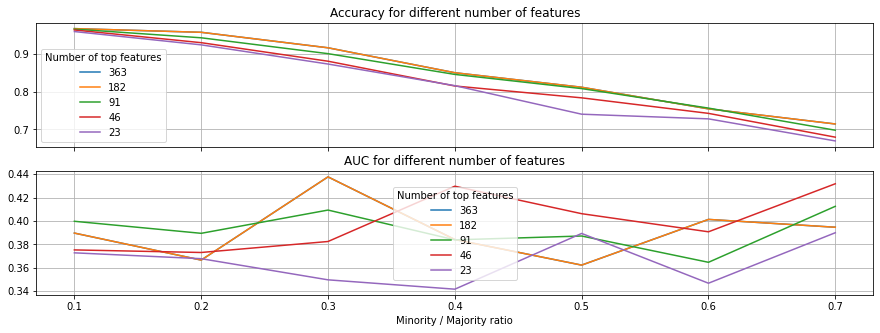

In [167]:
accuracy_AUC_plot(result_undersamling)

#### Appending new row of result in to the table 

In [168]:
# append data into result table

def result(y_test, prediction):
    
    """Append a new row of result into an dataframe below:
    

    result_table = pd.DataFrame(columns = ['Mino/Majo ratio','Number of features',
                                            'Accuracy','AUC', 'TP', 'FP', 
                                            'TN', 'FN', 'sensitivity', 
                                            'specificity', 'Runing time'])
        
    Args: 
        y_test (dataframe): test set
        prediction (dataframe): predicting result

    Returns:
        result_table (dataframe): result table with ritio class, matrix, and parameters 
    """

    auc = round(roc_auc_score(y_test, prediction[0]),4)
    acc = round(accuracy_score(y_test, prediction['outcome']),4)
    tp, fn, fp, tn  = confusion_matrix(y_test, prediction['outcome']).ravel()
    ppv = round(tp/(tp+fp),4)
    npv = round(tn/(tn+fn),4)
    sens = round(tp/(tp+fn),4)
    spec = round(tn/(tn+fp),4)

    result_line = list([mino_and_majo_ratio, int(n), acc, auc, tp, fp, tn, fn, sens, spec, running_time])
    result_table.loc[len(result_table)] = result_line
    
    return result_table

In [169]:
def accuracy_AUC_plot(result_table):
    
    """
    Visualization accuracy and AUC by minority/majority ratio, with numbers of features are different
    
    Arg(s):
    result_table (dataframe): data frame has 'Number of features', Mino/Majo ratio', 'Accuracy' and 'AUC' columns
    
    Return: 2 subplots
    """

    x = result_table.loc[result_table['Number of features'] == 363]['Mino/Majo ratio']

    number_feature = result_table['Number of features'].unique()
    fig, axs = plt.subplots(2, figsize = (15,5) ,sharex=True)

    axs[1].set_xlabel("Minority / Majority ratio")
    axs[0].set_title("Accuracy for different number of features")
    axs[1].set_title("AUC for different number of features")

    axs[0].grid()
    axs[1].grid()

    for i in number_feature:
        accuracy = result_table.loc[result_table['Number of features'] == i]['Accuracy']
        axs[0].plot(x, accuracy, label= i)
        axs[0].legend()
        axs[0].legend(title = "Number of top features")

    for i in number_feature:
        AUC = result_table.loc[result_table['Number of features'] == i]['AUC']

        axs[1].plot(x, AUC, label = i)
        axs[1].legend()
        axs[1].legend(title = "Number of top features")

        

#### Put it all together

Resamling data by using undersampling method then run the xgbost model





In [ ]:
# run model with under sampling

result_table = pd.DataFrame(columns = ['Mino/Majo ratio','Number of features',
                                        'Accuracy','AUC', 'TP', 'FP', 
                                        'TN', 'FN', 'Sensitivity', 
                                        'Specificity', 'Runing time'])

under_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for i in under_ratio:
    
    X_train_blc, y_train_blc= balancing(X_train, y_train, ratio = i, type = "undersampling")
    n = len(X_train.columns)
    
    X_test_loop = X_test.copy()
    
    mino_and_majo_ratio  = i
    while n >= 30:
        
        prediction, running_time, feature_imp = xgb_default (X_train = X_train_blc, y_train = y_train_blc, X_test_loop = X_test_loop)

        result_undersamling = result(y_test = y_test , prediction = prediction)  
     
        X_train_blc, X_test_loop, n  = re_processing_data(X_train = X_train_blc, X_test_loop = X_test_loop, num_initial_feature = n, feature_list = feature_imp)

In [171]:
result_undersamling

,Mino/Majo ratio,Number of features,Accuracy,AUC,TP,FP,TN,FN,Sensitivity,Specificity,Runing time
0,0.1,363,0.8873,0.4878,2725,80,8,267,0.9108,0.0909,0 mins 0 seconds
1,0.1,182,0.9669,0.3958,2978,88,0,14,0.9953,0.0000,0 mins 0 seconds
2,0.1,91,0.9679,0.3883,2979,86,2,13,0.9957,0.0227,0 mins 0 seconds
3,0.1,46,0.9643,0.4093,2969,87,1,23,0.9923,0.0114,0 mins 0 seconds
4,0.2,363,0.8461,0.5025,2599,81,7,393,0.8686,0.0795,0 mins 0 seconds
5,0.2,182,0.9500,0.4113,2921,83,5,71,0.9763,0.0568,0 mins 0 seconds
6,0.2,91,0.9468,0.3931,2910,82,6,82,0.9726,0.0682,0 mins 0 seconds
7,0.2,46,0.9321,0.4230,2866,83,5,126,0.9579,0.0568,0 mins 0 seconds
8,0.3,363,0.8539,0.5003,2621,79,9,371,0.8760,0.1023,0 mins 0 seconds
9,0.3,182,0.9231,0.4139,2834,79,9,158,0.9472,0.1023,0 mins 0 seconds


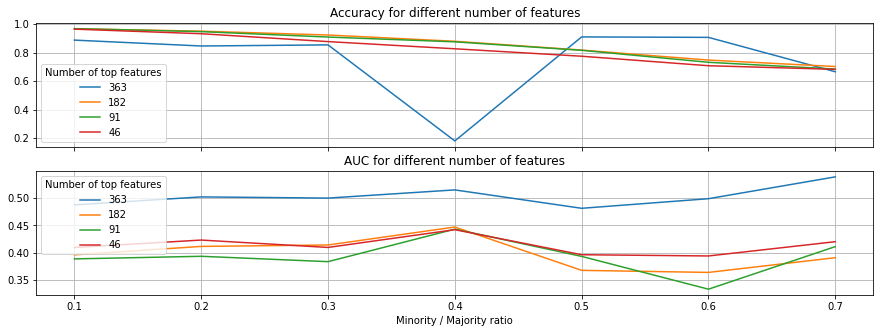

In [172]:
accuracy_AUC_plot(result_undersamling)


## Backward feature selection and combined over and under sampling
Resamling data by using combination both undersampling and oversampling method then run the xgbost model 
* Firstly, oversampling the manority class (1) 10 % of original data
* Undersampling the majority class (0) 50 - 90 % of new dataset above

In [ ]:
# Run model with combination under and over sampling
result_table = pd.DataFrame(columns = ['Mino/Majo ratio','Number of features',
                                        'Accuracy','AUC', 'TP', 'FP', 
                                        'TN', 'FN', 'Sensitivity', 
                                        'Specificity', 'Runing time'])

ratio_1 = [(0.1, 0.3), (0.1, 0.4), (0.1, 0.5), (0.1, 0.6), (0.1, 0.7), (0.1, 0.8), (0.1, 0.9)]

for i,j in ratio_1:     # i for undersampling ratio
                        # j for oversampling ratio
                        
    X_train_blc, y_train_blc = combined_both(X_train, y_train, under_ratio= i, over_ratio =j)
    n = len(X_train.columns)
    
    X_test_loop = X_test.copy()
    
    mino_and_majo_ratio  = j
    while n >= 30:
        
        prediction, running_time, feature_imp = xgb_default (X_train = X_train_blc, y_train = y_train_blc, X_test_loop = X_test_loop)

        result_combined= result(y_test = y_test , prediction = prediction)  
     
        X_train_blc, X_test_loop, n  = re_processing_data(X_train = X_train_blc, X_test_loop = X_test_loop, num_initial_feature = n, feature_list = feature_imp)

In [174]:
result_combined

,Mino/Majo ratio,Number of features,Accuracy,AUC,TP,FP,TN,FN,Sensitivity,Specificity,Runing time
0,0.3,363,0.7429,0.4440,2263,63,25,729,0.7564,0.2841,0 mins 0 seconds
1,0.3,182,0.9643,0.3730,2970,88,0,22,0.9926,0.0000,0 mins 0 seconds
2,0.3,91,0.9623,0.3981,2960,84,4,32,0.9893,0.0455,0 mins 0 seconds
3,0.3,46,0.9549,0.4259,2938,85,3,54,0.9820,0.0341,0 mins 0 seconds
4,0.4,363,0.7909,0.4566,2411,63,25,581,0.8058,0.2841,0 mins 0 seconds
5,0.4,182,0.9679,0.3670,2977,84,4,15,0.9950,0.0455,0 mins 0 seconds
6,0.4,91,0.9607,0.4030,2956,85,3,36,0.9880,0.0341,0 mins 0 seconds
7,0.4,46,0.9552,0.4313,2938,84,4,54,0.9820,0.0455,0 mins 0 seconds
8,0.5,363,0.9068,0.4834,2788,83,5,204,0.9318,0.0568,0 mins 0 seconds
9,0.5,182,0.9669,0.3794,2977,87,1,15,0.9950,0.0114,0 mins 0 seconds


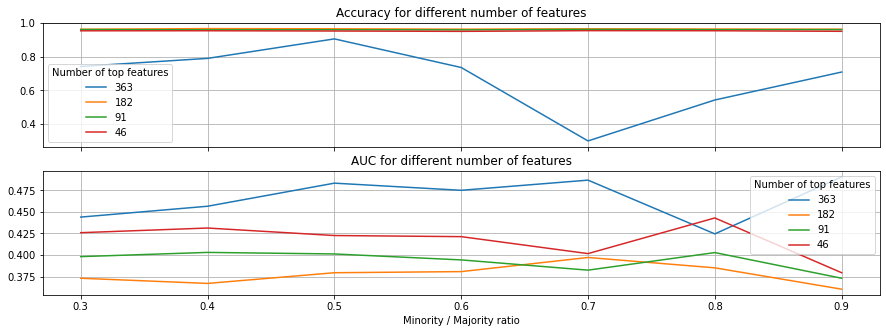

In [175]:
accuracy_AUC_plot(result_combined)

## Backward feature selection and over sampling

In [ ]:
# run model with over sampling
result_table = pd.DataFrame(columns = ['Mino/Majo ratio','Number of features',
                                        'Accuracy','AUC', 'TP', 'FP', 
                                        'TN', 'FN', 'Sensitivity', 
                                        'Specificity', 'Runing time'])

over_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for i in over_ratio:
    
    X_train_blc, y_train_blc = balancing(X_train, y_train, ratio = i, type = "oversampling")
    n = len(X_train.columns)
    X_test_loop = X_test.copy()
    mino_and_majo_ratio  = i
    
    while n >= 30:
        
        prediction, running_time, feature_imp = xgb_default (X_train = X_train_blc, y_train = y_train_blc, X_test_loop = X_test_loop)

        result_oversampling = result(y_test = y_test , prediction = prediction)  
     
        X_train_blc, X_test_loop, n  = re_processing_data(X_train = X_train_blc, X_test_loop = X_test_loop, num_initial_feature = n, feature_list = feature_imp)

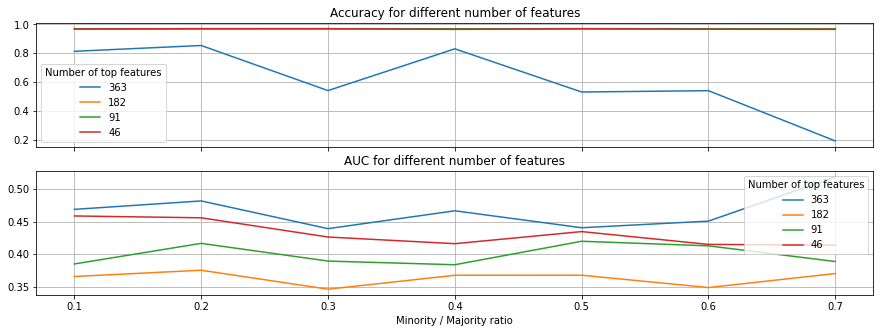

In [177]:
accuracy_AUC_plot(result_oversampling)

## Forward feature selection and over sampling

In [ ]:
# run model with over sampling
result_table = pd.DataFrame(columns = ['Mino/Majo ratio','Number of features',
                                        'Accuracy','AUC', 'TP', 'FP', 
                                        'TN', 'FN', 'Sensitivity', 
                                        'Specificity', 'Runing time'])

over_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for i in over_ratio:
    
    X_train_blc, y_train_blc = balancing(X_train, y_train, ratio = i, type = "oversampling")
    n = len(X_train.columns)*2
    X_test_loop = X_test.copy()
    mino_and_majo_ratio  = i
    
    while n >= 30:
        X_train_blc, X_test_loop, n  = re_processing_data_coor_matrix(X_train = X_train_blc, y_train = y_train_blc, X_test_loop = X_test_loop, num_initial_feature = n )
        
        prediction, running_time, feature_imp = xgb_default (X_train = X_train_blc, y_train = y_train_blc, X_test_loop = X_test_loop)

        result_oversampling = result(y_test = y_test , prediction = prediction)  

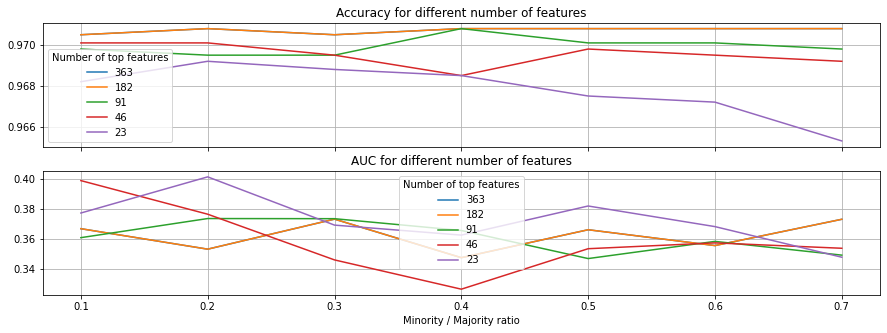

In [179]:
accuracy_AUC_plot(result_oversampling)

## Base line model 

In [ ]:
###### Based line model 

# run model with under sampling



result_table = pd.DataFrame(columns = ['Mino/Majo ratio','Number of features',
                                        'Accuracy','AUC', 'TP', 'FP', 
                                        'TN', 'FN', 'Sensitivity', 
                                        'Specificity', 'Runing time'])

# under_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

#for i in under_ratio:
     
 #   X_train_blc, y_train_blc= balancing(X_train, y_train, ratio = i, type = "undersampling")
    
n = len(X_train.columns)*2

X_test_loop = X_test.copy()

mino_and_majo_ratio  = 0.03
while n >= 30:
    
    X_train, X_test_loop, n  = re_processing_data_coor_matrix(X_train = X_train, y_train = y_train, X_test_loop = X_test_loop, num_initial_feature = n )
    
    prediction, running_time, feature_imp = xgb_default (X_train = X_train, y_train = y_train, X_test_loop = X_test_loop)

    result_baseline = result(y_test = y_test , prediction = prediction)  

In [153]:
result_baseline

,Mino/Majo ratio,Number of features,Accuracy,AUC,TP,FP,TN,FN,Sensitivity,Specificity,Runing time
0,0.03,363,0.9711,0.3712,2991,88,0,1,0.9997,0.0,0 mins 1 seconds
1,0.03,182,0.9711,0.3712,2991,88,0,1,0.9997,0.0,0 mins 1 seconds
2,0.03,91,0.9705,0.3946,2989,88,0,3,0.9990,0.0,0 mins 0 seconds
3,0.03,46,0.9705,0.3534,2989,88,0,3,0.9990,0.0,0 mins 0 seconds
4,0.03,23,0.9708,0.3532,2990,88,0,2,0.9993,0.0,0 mins 0 seconds
